In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, classification_report


# Processing Flight Data

In [3]:
# Load the weather, departure, and arrival data
departure_data = pd.read_csv('data/ATL_Departure_Data.csv')
arrival_data = pd.read_csv('data/ORD_Arrival_Data.csv')
weather_data = pd.read_csv('data/weather_data.csv')

# Merge datasets
merged_data = pd.merge(departure_data, arrival_data, on=['Flight Number', 'Date (MM/DD/YYYY)', 'Tail Number'], how='inner')

selected_columns = [
    'Date (MM/DD/YYYY)','Flight Number', 
    'Scheduled departure time', 'Actual departure time', 
    'Scheduled Arrival Time', 'Actual Arrival Time', 
    'Departure delay (Minutes)', 'Arrival Delay (Minutes)'
]

selected_data = merged_data[selected_columns].rename(columns={
    'Date (MM/DD/YYYY)': 'Date'
})

# Convert delay columns to numeric
selected_data['Departure delay (Minutes)'] = pd.to_numeric(selected_data['Departure delay (Minutes)'], errors='coerce')
selected_data['Arrival Delay (Minutes)'] = pd.to_numeric(selected_data['Arrival Delay (Minutes)'], errors='coerce')

# Create 'Delayed' column: 1 if delayed, 0 if on-time
selected_data['IsDelayed'] = ((selected_data['Departure delay (Minutes)'] > 0) | 
                              (selected_data['Arrival Delay (Minutes)'] > 0)).astype(int)


# Drop rows with missing delay data
selected_data = selected_data.dropna(subset=['Departure delay (Minutes)', 'Arrival Delay (Minutes)'])

# Feature Engineering
selected_data['Scheduled departure time'] = pd.to_datetime(selected_data['Scheduled departure time'], format='%H:%M')
selected_data['Actual departure time'] = pd.to_datetime(selected_data['Actual departure time'], format='%H:%M')

# Calculate the difference between scheduled and actual departure times
selected_data['Departure Time Difference (Minutes)'] = (selected_data['Actual departure time'] - selected_data['Scheduled departure time']).dt.total_seconds() / 60

# Rename weather data columns 
selected_weather_data = weather_data[['DATE', 'AWND', 'PRCP', 'TAVG']].copy()
selected_weather_data.loc[:, 'DATE'] = pd.to_datetime(selected_weather_data['DATE']).dt.strftime('%-m/%-d/%y')
selected_weather_data = selected_weather_data.rename(columns={
    'DATE': 'Date',
    'AWND': 'Average Wind Speed',
    'PRCP': 'Precipitation',
    'TAVG': 'Average Temperature'
})

# Merge the flight and weather data
merged_final_data = pd.merge(selected_data, selected_weather_data, on=['Date'], how='inner')

# Create weather-related features
merged_final_data['Weather Impact (Wind + Precipitation)'] = merged_final_data['Average Wind Speed'] + merged_final_data['Precipitation']
merged_final_data['Bad Weather'] = (merged_final_data['Average Wind Speed'] > 20) | (merged_final_data['Precipitation'] > 0.5)
merged_final_data['Hot Weather'] = (merged_final_data['Average Temperature'] > 85).astype(int)

# Create time-related features
merged_final_data['Hour of Day'] = merged_final_data['Scheduled departure time'].dt.hour
merged_final_data['Day of Week'] = merged_final_data['Scheduled departure time'].dt.dayofweek
merged_final_data['Time of Day'] = pd.cut(merged_final_data['Hour of Day'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)

# Create Delayed Due to Weather feature
merged_final_data['Delayed Due to Weather'] = ((merged_final_data['Bad Weather'] == 1) & (merged_final_data['IsDelayed'] == 1)).astype(int)

# Save the final dataset with features
merged_final_data.to_csv('final_data_with_features.csv', index=False)

print("Final dataset with features has been saved.")


Final dataset with features has been saved.


# Exploratory Data Analysis (EDA)

## Scatter Plot: Temperature vs. Departure Delay

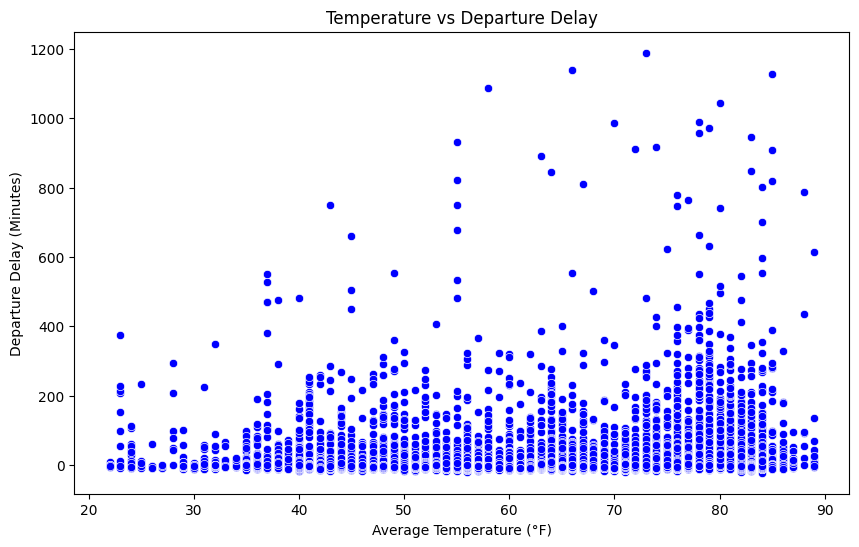

In [4]:
# Scatter plot for temperature vs departure delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Average Temperature', y='Departure delay (Minutes)', data=merged_final_data, color='blue')
plt.title('Temperature vs Departure Delay')
plt.xlabel('Average Temperature (°F)')
plt.ylabel('Departure Delay (Minutes)')
plt.show()


### Scatter Plot: Wind Speed vs. Arrival Delay

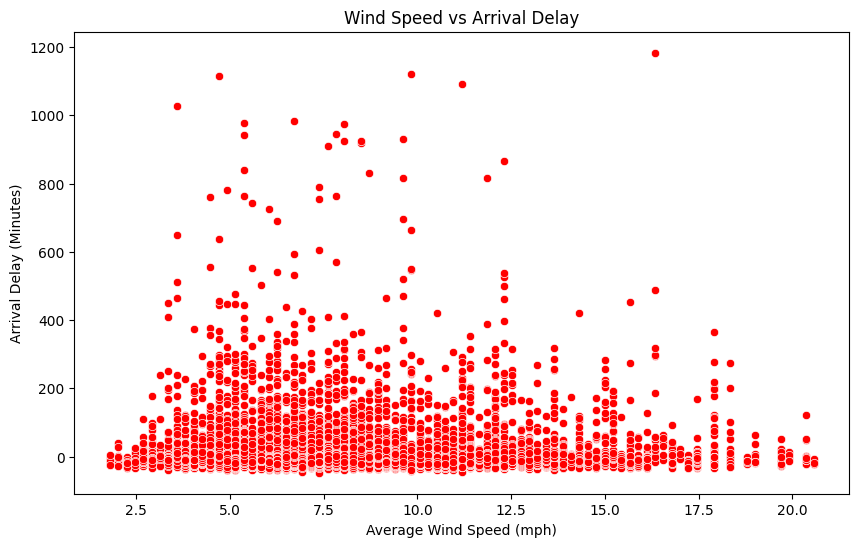

In [5]:
# Scatter plot for wind speed vs arrival delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Average Wind Speed', y='Arrival Delay (Minutes)', data=merged_final_data, color='red')
plt.title('Wind Speed vs Arrival Delay')
plt.xlabel('Average Wind Speed (mph)')
plt.ylabel('Arrival Delay (Minutes)')
plt.show()


### Scatter Plot: Precipitation vs. Departure Delay

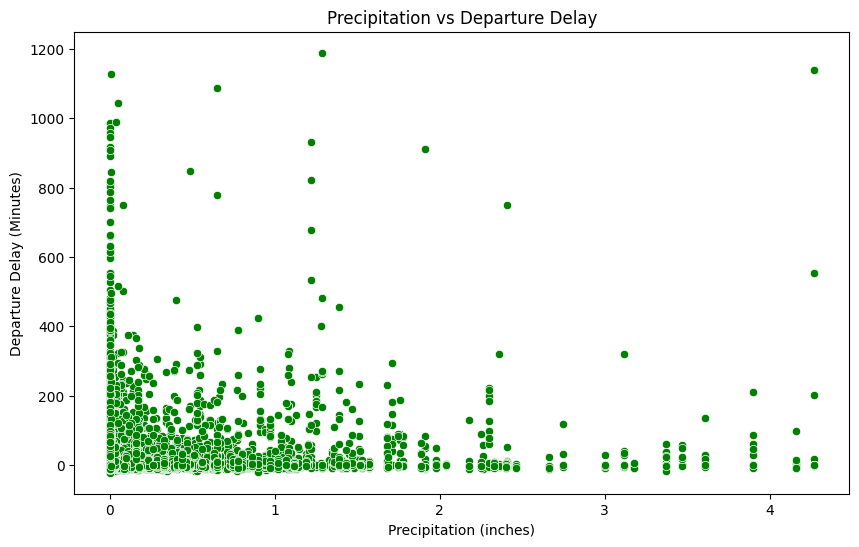

In [6]:
# Scatter plot for precipitation vs departure delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Precipitation', y='Departure delay (Minutes)', data=merged_final_data, color='green')
plt.title('Precipitation vs Departure Delay')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Departure Delay (Minutes)')
plt.show()


### Correlation Heatmap

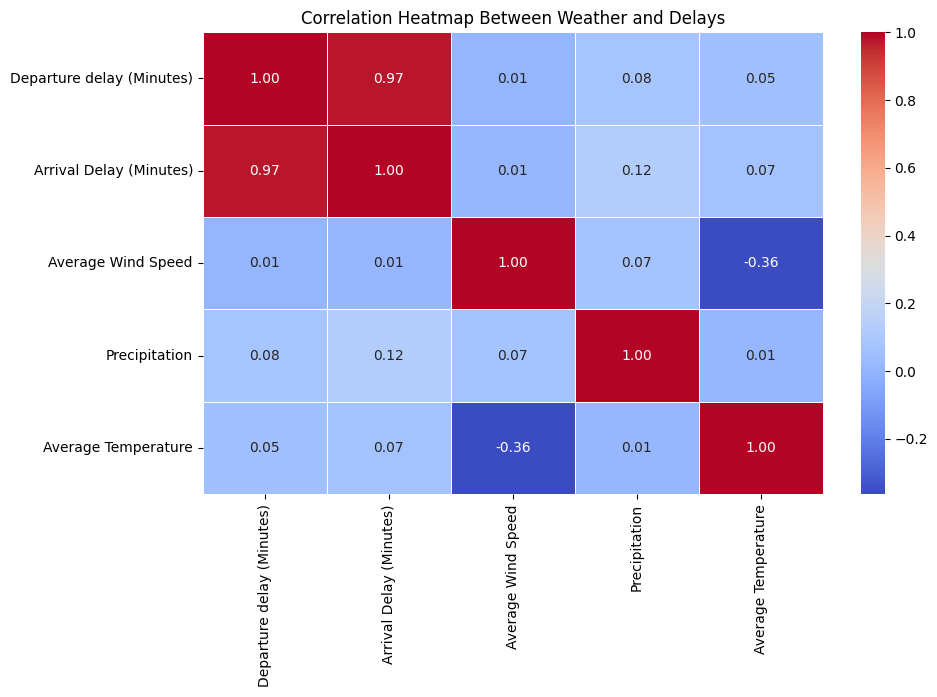

In [7]:
# Calculate correlations
correlation_matrix = merged_final_data[['Departure delay (Minutes)', 'Arrival Delay (Minutes)', 
                                        'Average Wind Speed', 'Precipitation', 'Average Temperature']].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap Between Weather and Delays')
plt.show()


# Model Building

In [8]:
# Load the dataset
data = pd.read_csv('final_data_with_features.csv')

# Convert Date column and preprocess as previously discussed
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y', errors='coerce')
    data['Month'] = data['Date'].dt.month
    data['Day_of_Week'] = data['Date'].dt.weekday
    data['Year'] = data['Date'].dt.year
    data['Day_of_Year'] = data['Date'].dt.dayofyear
    data = data.drop(columns=['Date'])

# Feature engineering for forecast vs actual weather difference
data['Wind Deviation'] = np.random.normal(0, 0.5, len(data))
data['Temp Deviation'] = np.random.normal(0, 2, len(data))

# Handle categorical variables with frequency encoding
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = data[col].map(data[col].value_counts())  # Frequency encode

# Ensure no missing values
data = data.fillna(0)

# Define features and target variable
X = data.drop(columns=['IsDelayed'])
y = data['IsDelayed']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Base model (Logistic Regression as an example)
model = LogisticRegression()
model.fit(X_train, y_train)

# Deterministic predictions (without uncertainty)
y_pred_deterministic = model.predict(X_test)
y_pred_prob_deterministic = model.predict_proba(X_test)[:, 1]

# Incorporating Uncertainty

## Monte Carlo Simulation for Uncertainty

In [9]:
n_simulations = 100
uncertainty_results = []

for _ in range(n_simulations):
    # Simulate small perturbations in weather conditions
    X_simulated = X_test.copy()
    X_simulated[:, X.columns.get_loc('Average Wind Speed')] += np.random.normal(0, 0.5, X_simulated.shape[0])
    X_simulated[:, X.columns.get_loc('Average Temperature')] += np.random.normal(0, 2, X_simulated.shape[0])
    
    # Predict with logistic regression
    uncertainty_results.append(model.predict_proba(X_simulated)[:, 1])

# Convert predictions to numpy array and calculate mean and standard deviation
uncertainty_results = np.array(uncertainty_results)
mean_uncertain_probs = uncertainty_results.mean(axis=0)  # Mean prediction
std_uncertain_probs = uncertainty_results.std(axis=0)    # Standard deviation for uncertainty analysis

# Convert to binary predictions based on a threshold (e.g., 0.5)
y_pred_uncertain = (mean_uncertain_probs > 0.5).astype(int)

# Model Evaluation

Deterministic Model - Accuracy: 0.9456371191135734, Precision: 0.962015503875969, Recall: 0.9199406968124537, ROC AUC: 0.9903902055333265
Probabilistic Model (Monte Carlo) - Accuracy: 0.9449445983379502, Precision: 0.9619565217391305, Recall: 0.9184581171237954, ROC AUC: 0.990376718778524


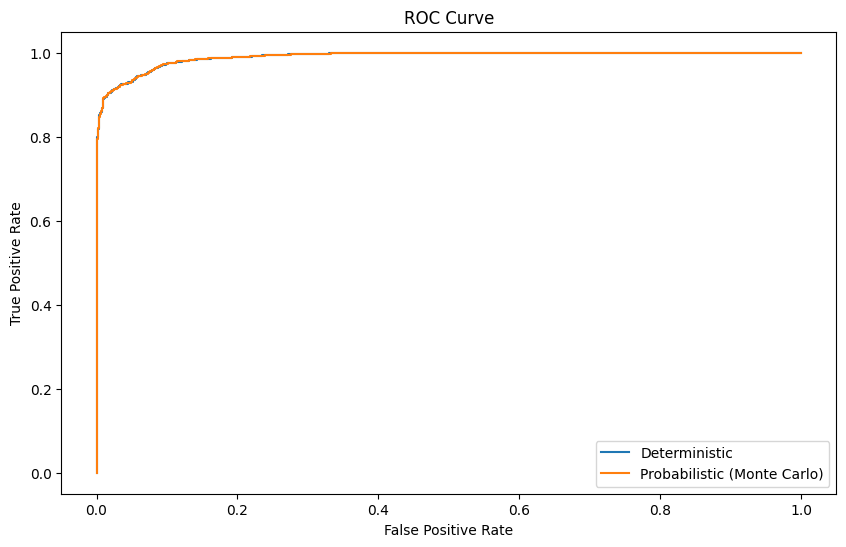

In [10]:
# Deterministic model evaluation
accuracy_det = accuracy_score(y_test, y_pred_deterministic)
precision_det = precision_score(y_test, y_pred_deterministic)
recall_det = recall_score(y_test, y_pred_deterministic)
roc_auc_det = roc_auc_score(y_test, y_pred_prob_deterministic)

# Uncertain (probabilistic) model evaluation
accuracy_unc = accuracy_score(y_test, y_pred_uncertain)
precision_unc = precision_score(y_test, y_pred_uncertain)
recall_unc = recall_score(y_test, y_pred_uncertain)
roc_auc_unc = roc_auc_score(y_test, mean_uncertain_probs)

# Print results
print(f"Deterministic Model - Accuracy: {accuracy_det}, Precision: {precision_det}, Recall: {recall_det}, ROC AUC: {roc_auc_det}")
print(f"Probabilistic Model (Monte Carlo) - Accuracy: {accuracy_unc}, Precision: {precision_unc}, Recall: {recall_unc}, ROC AUC: {roc_auc_unc}")

# ROC Curve
fpr_det, tpr_det, _ = roc_curve(y_test, y_pred_prob_deterministic)
fpr_unc, tpr_unc, _ = roc_curve(y_test, mean_uncertain_probs)

plt.figure(figsize=(10, 6))
plt.plot(fpr_det, tpr_det, label='Deterministic')
plt.plot(fpr_unc, tpr_unc, label='Probabilistic (Monte Carlo)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# Visualization of Uncertainty Impact on Delay Probabilities

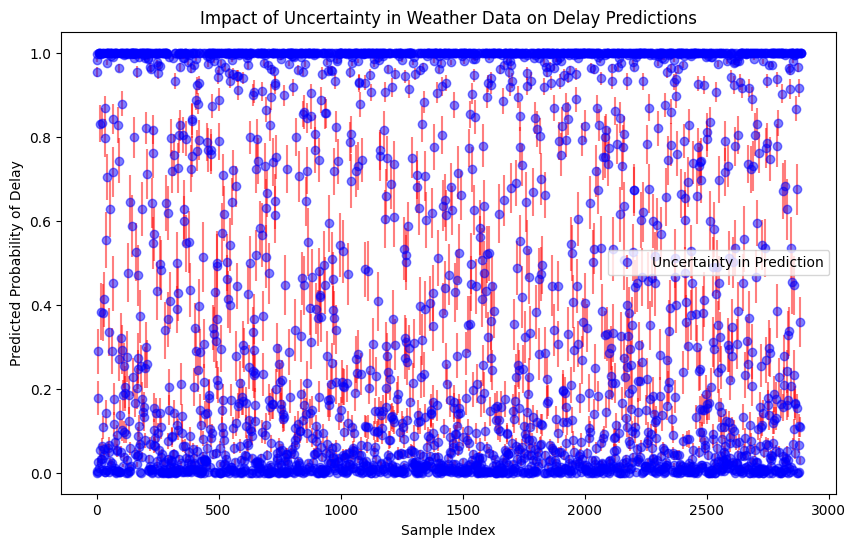

In [11]:
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(mean_uncertain_probs)), mean_uncertain_probs, yerr=std_uncertain_probs, fmt='o', color='b', ecolor='r', alpha=0.5, label='Uncertainty in Prediction')
plt.title('Impact of Uncertainty in Weather Data on Delay Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability of Delay')
plt.legend()
plt.show()




# Distribution of Predicted Probabilities for Delays

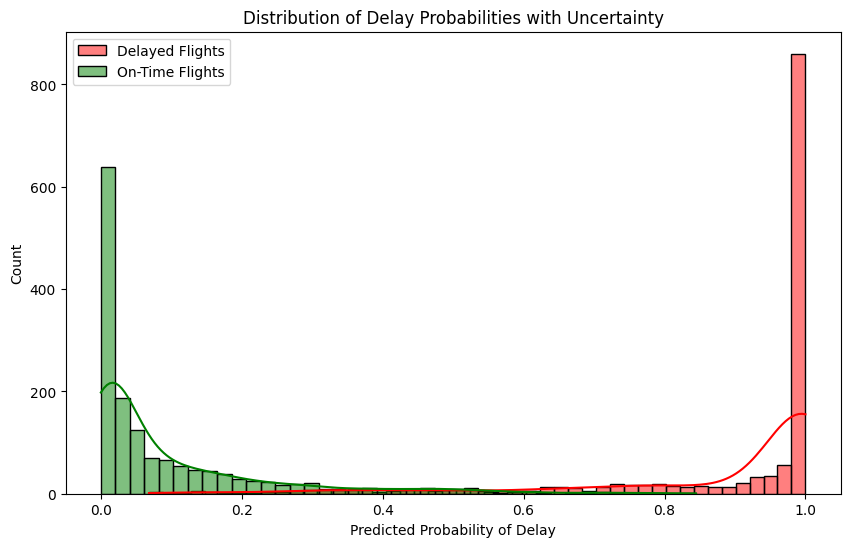

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(mean_uncertain_probs[y_test == 1], color='r', label='Delayed Flights', kde=True)
sns.histplot(mean_uncertain_probs[y_test == 0], color='g', label='On-Time Flights', kde=True)
plt.title('Distribution of Delay Probabilities with Uncertainty')
plt.xlabel('Predicted Probability of Delay')
plt.legend()
plt.show()

# Calculate correlation matrix for the features used

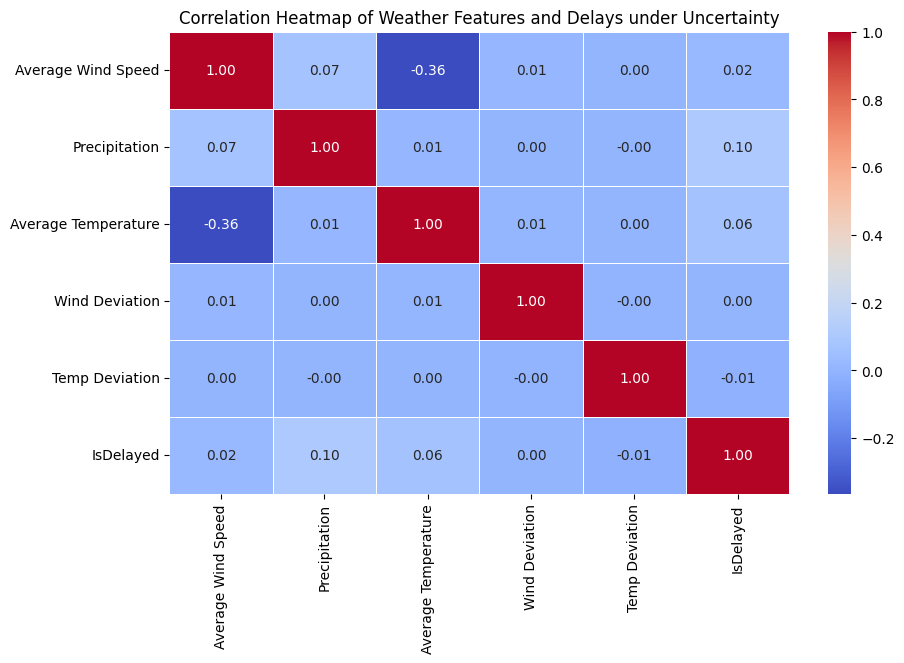

In [13]:

features_to_include = ['Average Wind Speed', 'Precipitation', 'Average Temperature', 'Wind Deviation', 'Temp Deviation']
correlation_matrix = data[features_to_include + ['IsDelayed']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Weather Features and Delays under Uncertainty')
plt.show()